Notes for Jacopo:


<br>
This EDAA  is for Walter, in order to find togheter a mattern or a signal that needs to be investigated<br>


In [4]:
kernel='j'

In [8]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/EDA'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from HWK_package.functions import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import sys
import os
import numpy as np
module_path = '/Users/jacoponudo/Documents/thesis/src/EDA'
sys.path.append(module_path)
from EDA_package.function import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency

In [13]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

# IAT nella interazione user-root


*Escludiamo le interazione con meno di 3 commenti, calcoliamo la posizione rispetto all'inizio e la fine della conversazione ∈ [0,1]*

In [36]:
data=data[data['number_of_comments_by_user_in_thread']>5].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

*L'IAT non è omogeneo nella conversazone.
Notiamo che l'inter arrival time tende a crescere nella fase finale della conversazione, l'utente si stufa, risponde sempre meno prontamente, fino a uscire.*

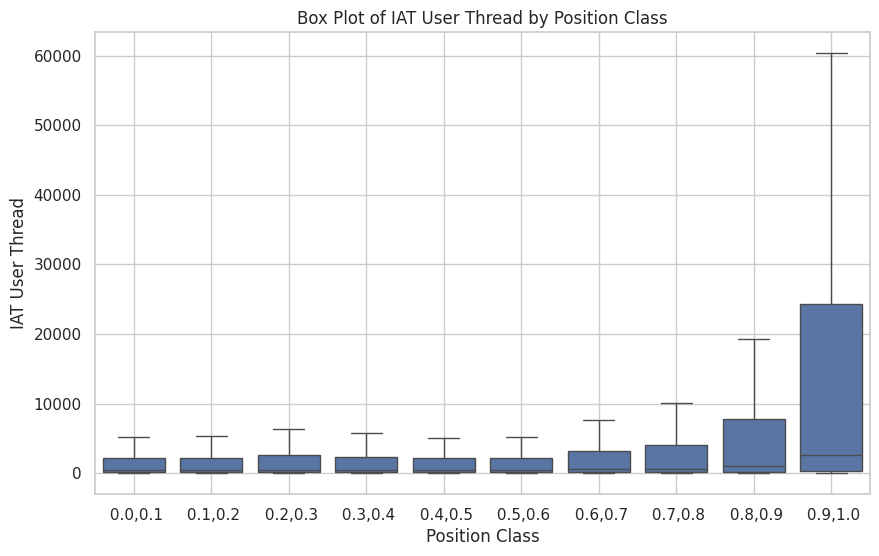

In [155]:
number_of_classes=10
data['position_class'] = pd.cut(data['position_user_thread'], bins=number_of_classes, labels=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='IAT_user_thread', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()

*Osserviamo come se la fase finale della conversazione risulta piu rilassata, con ritmi piu flebili, la conversazione tende ad essere meno tosissica.*

<ipython-input-200-cfebcf1bcc51>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set2')


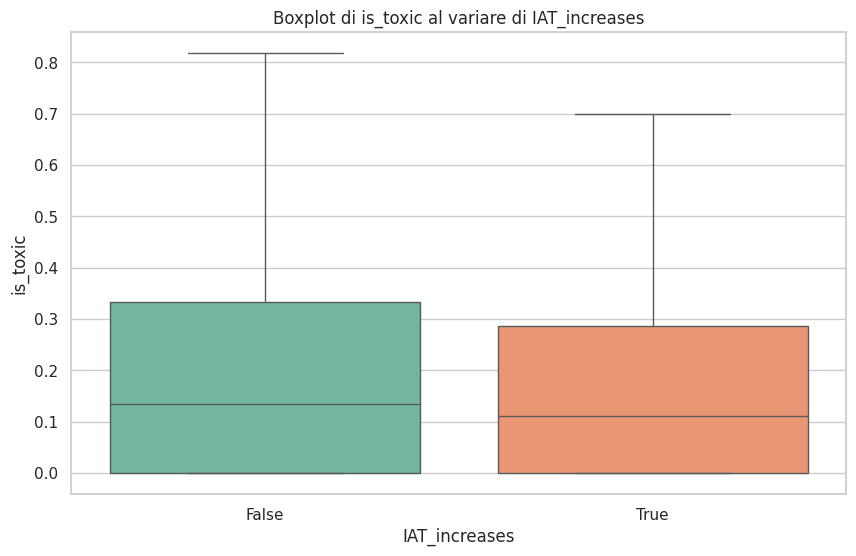

In [200]:
# Trova l'IAT mediana e finale di ogni conversazione per ogni utente
mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

# Unisci i due DataFrame sulla chiave 'user' e 'root_submission'
merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))


data['is_toxic']=data['toxicity_score']>0.6
toxicity=data.groupby(['user','root_submission'])['is_toxic'].mean()

merged_df=merged_df.merge(toxicity,on=['user', 'root_submission'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set2')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()

<ipython-input-198-ec17394883c5>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df, showfliers=False, palette='Set2')


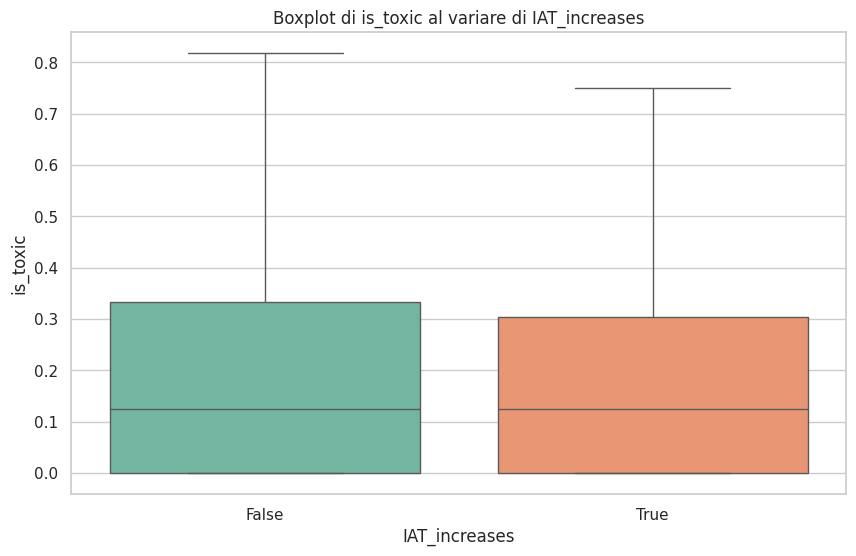

In [198]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def manipulate_data_and_return_merged_df(data, number_of_classes=5):
    # Trova l'IAT mediana e finale di ogni conversazione per ogni utente
    mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
    final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
    semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

    # Unisci i due DataFrame sulla chiave 'user' e 'root_submission'
    merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
    merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

    merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))

    data['is_toxic'] = data['toxicity_score'] > 0.6
    toxicity = data.groupby(['user','root_submission'])['is_toxic'].mean()

    merged_df = merged_df.merge(toxicity, on=['user', 'root_submission'])

    return merged_df

# Utilizzare la funzione per manipolare i dati e ottenere merged_df
merged_df = manipulate_data_and_return_merged_df(data)

# Creare il boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df, showfliers=False, palette='Set2')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()


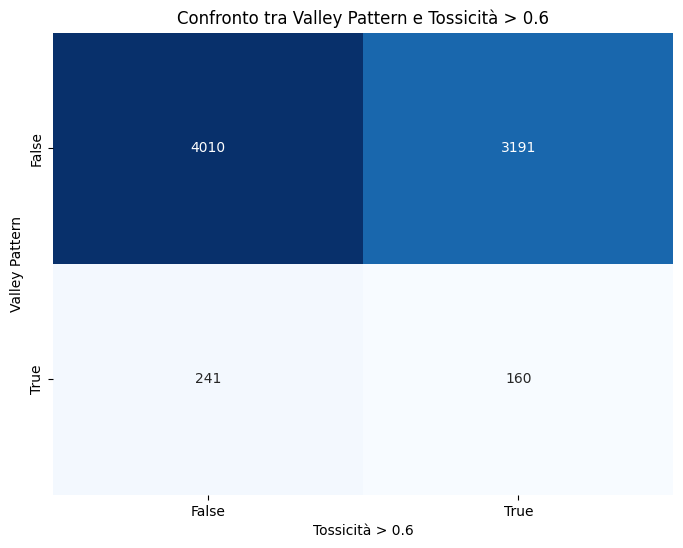

Dividendo le conversazioni in quelle che  subiscono un incremento del IAT nella fase finale e quelle che non lo fanno riscontriamo che **la tossicià è maggiore** in queste ultime.

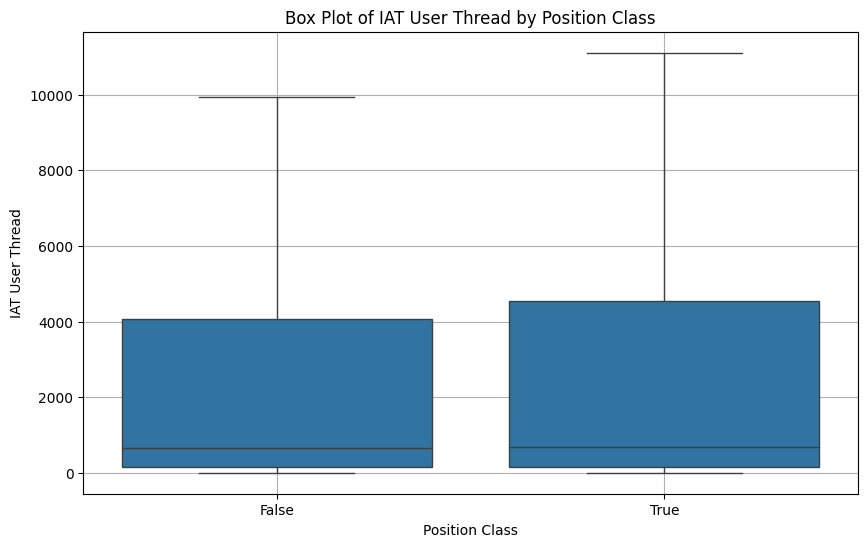

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the columns 'position_user_thread' and 'IAT_user_thread'

# Divide 'position_user_thread' into six classes
data['is_toxic'] = data['toxicity_score']>0.6

# Create box plots of 'IAT_user_thread' for each class
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_toxic', y='IAT_user_thread', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.grid(True)
plt.show()


L'inter arrival time tende a essere piu lungo alla fine e all inizio

In [ ]:
bins = np.arange(0, 1.01, 0.2)

Creazione dell'istogramma

In [ ]:
plt.hist(max_positions, bins=bins, edgecolor='black', align='left')

Aggiunta del titolo e delle etichette degli assi

In [ ]:
plt.title('Istogramma delle Posizioni Massime')
plt.xlabel('Posizione del commento')
plt.ylabel('Frequenza')

Mostra l'istogramma

In [ ]:
plt.show()

Se non c'è un effetto a parabola dell'IAT, ci sono delle alterazioni della  tossicità?


<br>
# PLOT 1<br>
import seaborn as sns<br>
import matplotlib.pyplot as plt<br>
columns_to_plot = ['t2', 't3', 't4', 't5', 't6','t7', 't8', 't9']<br>
result_df.columns<br>
melted_df = result_df[columns_to_plot].melt(var_name='Columns', value_name='Values')<br>
plt.figure(figsize=(10, 6))<br>
sns.boxplot(x='Columns', y='Values', data=melted_df,showfliers=False)<br>
plt.title('Boxplot of Inter Arrival Time for Conversations of len9')<br>
plt.show()<br>
# PLOT 2<br>
import matplotlib.pyplot as plt<br>
x_column = 0<br>
y_column = 'toxicity_t2'<br>
plt.figure(figsize=(8, 6))<br>
plt.scatter(standardized_df.iloc[:, x_column], result_df.iloc[:, 10], alpha=0.5, s=2)<br>
plt.title(f'Scatter plot tra {x_column} e {y_column}')<br>
plt.xlabel(x_column)<br>
plt.ylabel(y_column)<br>
plt.show()<br>
